# Assignment III

### Github [(https://github.com/bestfranklinAI/Cython-HPC-)](https://github.com/bestfranklinAI/Cython-HPC-)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import cProfile

In [1]:
from functools import wraps
import time

times = {}

def times_init():
    times.clear()
    times["pylist"] = []
    times["pyarray"] = []
    times["nparray"] = []
    times['GPU'] = []
    times["nvidia"] = []

# decorator to time
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        times[fn.__name__].append(t2 - t1)
        return result
    return measure_time

## Exercise 1 - Gauss-Seidel for Poisson Solver

### Task 1.1

N = 10
@timefn: pylist took 0.016114234924316406 seconds
@timefn: pyarray took 0.01741194725036621 seconds
@timefn: nparray took 0.027540922164916992 seconds
N = 25
@timefn: pylist took 0.08029794692993164 seconds
@timefn: pyarray took 0.10222697257995605 seconds
@timefn: nparray took 0.20291566848754883 seconds
N = 50
@timefn: pylist took 0.3435990810394287 seconds
@timefn: pyarray took 0.4604320526123047 seconds
@timefn: nparray took 0.8927969932556152 seconds
N = 75
@timefn: pylist took 0.7912530899047852 seconds
@timefn: pyarray took 1.0671000480651855 seconds
@timefn: nparray took 2.1202292442321777 seconds
N = 100
@timefn: pylist took 1.5192461013793945 seconds
@timefn: pyarray took 1.988356113433838 seconds
@timefn: nparray took 3.7797138690948486 seconds


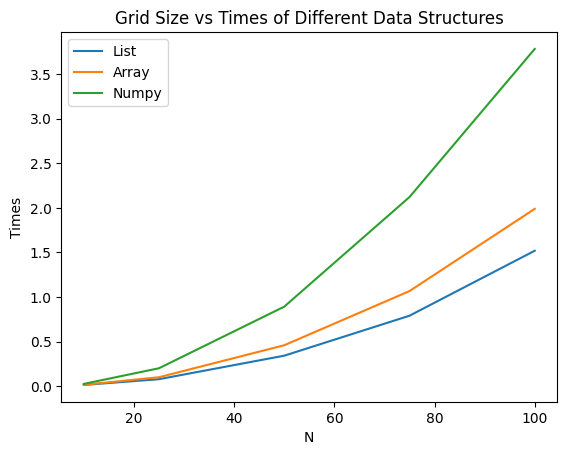

In [3]:
import array
import random
import numpy as np
import matplotlib.pyplot as plt

@timefn
def pylist(f, iterations):
    newf = [row.copy() for row in f]
    for _ in range(iterations):
        for i in range(1, len(newf) - 1):
            for j in range(1, len(newf) - 1):
                newf[i][j] = 0.25 * (newf[i][j + 1] + newf[i][j - 1] +
                                     newf[i + 1][j] + newf[i - 1][j])
    return newf

@timefn
def pyarray(f, iterations):
    newf = f.copy()
    for _ in range(iterations):
        for i in range(1, len(newf) - 1):
            for j in range(1, len(newf) - 1):
                newf[i][j] = 0.25 * (newf[i][j + 1] + newf[i][j - 1] +
                                     newf[i + 1][j] + newf[i - 1][j])
    return newf

@timefn
def nparray(f, iterations):
    newf = f.copy()
    for _ in range(iterations):
        # newf[1:-1, 1:-1] = 0.25 * (newf[1:-1, 2:] + newf[1:-1, :-2] +
        #                          newf[2:, 1:-1] + newf[:-2, 1:-1])
        for i in range(1,newf.shape[0]-1):
            for j in range(1,newf.shape[1]-1):
                newf[i,j] = 0.25 * (newf[i,j+1] + newf[i,j-1] +
                                       newf[i+1,j] + newf[i-1,j])
    return newf

Ns = [10, 25, 50, 75, 100]

if __name__ == "__main__":
    times_init()
    for n, N in enumerate(Ns):
        print(f"N = {N}")
        a = [[random.uniform(1, 100) for _ in range(N)] for _ in range(N)]
        # Python list
        pylist(a, 1000)
        # Python array
        pyarray([array.array('f', row) for row in a], 1000)
        # Numpy array
        nparray(np.array(a), 1000)
        print(f"@timefn: pylist took {times['pylist'][n]} seconds")
        print(f"@timefn: pyarray took {times['pyarray'][n]} seconds")
        print(f"@timefn: nparray took {times['nparray'][n]} seconds")
    plt.plot(Ns, times["pylist"], label="List")
    plt.plot(Ns, times["pyarray"], label="Array")
    plt.plot(Ns, times["nparray"], label="Numpy")
    plt.title("Grid Size vs Times of Different Data Structures")
    plt.legend(loc="upper left")
    plt.xlabel("N")
    plt.ylabel("Times")
    plt.show()

### Task 1.2

#### gaussseidel.py

In [6]:
from line_profiler import profile

@profile
def gauss_seidel(f):
    newf = f.copy()
    for i in range(1,newf.shape[0]-1):
        for j in range(1,newf.shape[1]-1):
            newf[i,j] = 0.25 * (newf[i,j+1] + newf[i,j-1] +
                                   newf[i+1,j] + newf[i-1,j])
    return newf

if __name__ == "__main__":
    N = 100
    x = np.array([[random.uniform(1, 100) for _ in range(N)] for _ in range(N)])
    for i in range(1000):
        x = gauss_seidel(x)

In [7]:
! python -m kernprof -l gaussseidel.py
! python -m line_profiler gaussseidel.py.lprof

Wrote profile results to gaussseidel.py.lprof
Inspect results with:
python -m line_profiler -rmt "gaussseidel.py.lprof"
Timer unit: 1e-06 s

Total time: 9.26955 s
File: gaussseidel.py
Function: gauss_seidel at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           @profile
     6                                           def gauss_seidel(f):
     7      1000       3747.0      3.7      0.0      newf = f.copy()
     8     99000      10503.0      0.1      0.1      for i in range(1, newf.shape[0] - 1):
     9   9702000     965605.0      0.1     10.4          for j in range(1, newf.shape[1] - 1):
    10  28812000    5625909.0      0.2     60.7              newf[i, j] = 0.25 * (newf[i, j + 1] + newf[i, j - 1] +
    11  19208000    2663623.0      0.1     28.7                                   newf[i + 1, j] + newf[i - 1, j])
    12                                           
    13      1000        165.0      0.2      0.0      re

### Task 1.3

In [9]:
!cython -a gaussseidel.pyx

/opt/miniconda3/envs/hpc/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/franklin/Codes/COMP/High Performance Computing (KTH)/HW3/gaussseidel.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


![image](image/without_optimization.png)

### Task 1.4

In [10]:
!cython -a gauss.pyx

/opt/miniconda3/envs/hpc/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/franklin/Codes/COMP/High Performance Computing (KTH)/HW3/gauss.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


![image](image/with_optimization.png)

### Task 1.5

In [ ]:
import torch
import cupy as cp

In [ ]:
@timefn
def GPU(f, iterations=1000, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    f = f.to(device)
    for it in range(iterations):
        f = 0.25 * (torch.roll(f, shifts=1, dims=0) +
                    torch.roll(f, shifts=-1, dims=0) +
                    torch.roll(f, shifts=1, dims=1) +
                    torch.roll(f, shifts=-1, dims=1))
    return f

In [ ]:
def GPU_iterations(n):
  grid_size = n
  f_torch = torch.zeros((grid_size, grid_size), dtype=torch.float32)
  f_torch[grid_size//2, grid_size//2] = 1.0
  result_torch = GPU(f_torch, iterations=100)
  print('Max value:', result_torch.max().item())

In [ ]:
Ns = [10, 25, 50, 75, 100]


times_init()
for n in Ns:
    print(f"N = {N}")
    GPU_iterations(N)

![image](image/torch.png)

### Task 1.6

In [ ]:
import cupy as cp

In [ ]:
@timefn
def nvidia(f, iterations=1000):
    for it in range(iterations):
        f = 0.25 * (cp.roll(f, shift=1, axis=0) +
                    cp.roll(f, shift=-1, axis=0) +
                    cp.roll(f, shift=1, axis=1) +
                    cp.roll(f, shift=-1, axis=1))
    return f

In [ ]:
def nvidia_iterations(n):


  grid_size = n 
  f_cupy = cp.zeros((grid_size, grid_size), dtype=cp.float64)
  f_cupy[grid_size//2, grid_size//2] = 1.0
  result_cupy = nvidia(f_cupy, iterations=100)
  cp.cuda.Stream.null.synchronize()
  print('Max value:', cp.max(result_cupy).get())

In [ ]:
Ns = [10, 25, 50, 75, 100]


times_init()
for n in Ns:
    print(f"N = {N}")
    nvidia_iterations(N)

![image](image/cupy.png)

### Task 1.7

In [15]:
import gauss

def benchmark(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

grid_sizes = [100, 200, 400]
gs_times = []
jacobi_times = []
cython_times = []
pytorch_times = []
cupy_times = []

iterations = 50  # Use a smaller number for demonstration purposes

In [ ]:


for size in grid_sizes:
    print(f"\nGrid Size: {size}")
    f = np.zeros((size, size), dtype=np.float64)
    f[size//2, size//2] = 1.0
    
    # NumPy Gauss-Seidel
    _, t_gs = benchmark(pylist, f, iterations)
    gs_times.append(t_gs)
    print(f"NumPy Gauss-Seidel: {t_gs:.4f} sec")

    # NumPy Jacobi
    _, t_jacobi = benchmark(nparray, f, iterations)
    jacobi_times.append(t_jacobi)
    print(f"NumPy Jacobi: {t_jacobi:.4f} sec")

    # Cython Gauss-Seidel
    _, t_cython = benchmark(gauss.cython_gauss_seidel, f, iterations)
    cython_times.append(t_cython)
    print(f"Cython Gauss-Seidel: {t_cython:.4f} sec")

    # PyTorch Jacobi
    f_torch = torch.from_numpy(f).float()
    _, t_torch = benchmark(GPU, f_torch, iterations)
    pytorch_times.append(t_torch)
    print(f"PyTorch Jacobi: {t_torch:.4f} sec")

    # CuPy Jacobi
    f_cupy = cp.array(f)
    cp.cuda.Stream.null.synchronize()
    start = time.perf_counter()
    _ = nvidia(f_cupy, iterations)
    cp.cuda.Stream.null.synchronize()
    t_cupy = time.perf_counter() - start
    cupy_times.append(t_cupy)
    print(f"CuPy Jacobi: {t_cupy:.4f} sec")

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, gs_times, 'o-', label='NumPy Gauss-Seidel')
plt.plot(grid_sizes, jacobi_times, 's-', label='NumPy Jacobi')
# plt.plot(grid_sizes, cython_times, '^-', label='Cython Gauss-Seidel')
plt.plot(grid_sizes, pytorch_times, 'd-', label='PyTorch Jacobi')
plt.plot(grid_sizes, cupy_times, 'v-', label='CuPy Jacobi')
plt.xlabel('Grid Size')
plt.ylabel('Execution Time (sec)')
plt.title('Performance Comparison of Solvers')
plt.legend()
plt.grid(True)
plt.show()

![image](image/comparison.png)

The one with GPU has seen significant improvement in speed, while the numpy one without GPU remains as the slowest.

In [17]:
import gauss

N = 100
arr = np.array([[random.uniform(1, 100) for _ in range(N)] for _ in range(N)])
gauss.cython_gauss_seidel(arr, 1000)

array([[15.34998779,  7.07198273, 81.27156397, ..., 81.17868071,
        12.78488569, 23.94690078],
       [10.70246122, 25.64927854, 48.9316945 , ..., 53.5949884 ,
        28.08956988, 14.02130493],
       [35.21869902, 35.89098334, 42.99400896, ..., 47.35310207,
        31.95710213,  3.31183442],
       ...,
       [26.34357973, 49.54888343, 53.67329496, ..., 51.67885644,
        48.68880392, 43.92562834],
       [83.51624529, 58.22263926, 54.80784311, ..., 56.30646543,
        51.41483171, 46.19858131],
       [ 4.24149496, 45.01758808, 52.68768298, ..., 65.5521781 ,
        54.46547618, 17.12217905]])

### Task 1.8

In [18]:

final_grid, _ = benchmark(gauss.cython_gauss_seidel, f, iterations)


with h5py.File('final_grid.h5', 'w') as hf:
    hf.create_dataset('grid', data=final_grid)

print('Final grid saved to final_grid.h5')

Final grid saved to final_grid.h5


## Bonus Exercise - Fast Fractal Fun with Cython & GPUs

### Task B.1


### Task B.2

### Task B.3

### Optional Task